Objective 1: Data Collection and Cleaning: Import the necessary libraries, load the dataset, handle missing values, check data types, and ensure data is in the correct format for analysis.


In [39]:
# Import Necessary Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_rows', None)





In [40]:
# Load the Dataset

df = pd.read_csv('/content/rfm_data.csv')

df.head(10)


,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location
0,8814,2023-04-11,943.31,Product C,890075,Tokyo
1,2188,2023-04-11,463.70,Product A,176819,London
2,4608,2023-04-11,80.28,Product A,340062,New York
3,2559,2023-04-11,221.29,Product A,239145,London
4,9482,2023-04-11,739.56,Product A,194545,Paris
5,8483,2023-04-11,375.23,Product C,691194,Paris
6,8317,2023-04-11,272.56,Product B,826847,New York
7,6911,2023-04-11,433.33,Product C,963918,Tokyo
8,8993,2023-04-12,16.55,Product D,112426,New York
9,3519,2023-04-12,464.63,Product C,139726,New York


In [41]:
# Initial Data Check

# Shape of the dataset
print("Shape of the dataset:", df.shape)

# Basic information about the dataset
df.info()

# Summary statistics
df.describe()


Shape of the dataset: (1000, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerID          1000 non-null   int64  
 1   PurchaseDate        1000 non-null   object 
 2   TransactionAmount   1000 non-null   float64
 3   ProductInformation  1000 non-null   object 
 4   OrderID             1000 non-null   int64  
 5   Location            1000 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 47.0+ KB


,CustomerID,TransactionAmount,OrderID
count,1000.000000,1000.00000,1000.000000
mean,5554.789000,513.67781,554071.398000
std,2605.014863,286.09870,264695.448814
min,1011.000000,12.13000,100096.000000
25%,3273.000000,257.12000,313152.000000
50%,5538.000000,523.56500,564671.500000
75%,7821.750000,759.86000,783052.250000
max,9991.000000,999.44000,999695.000000


In [42]:
# Check and Handle Missing Values

# Check for missing values
df.isnull().sum()

# Optionally drop or fill missing values
# For example, dropping rows with any missing values:
df_cleaned = df.dropna()

# Or filling with median values (alternative approach)
# df.fillna(df.median(numeric_only=True), inplace=True)

# Re-check for missing values
df_cleaned.isnull().sum()


,0
CustomerID,0
PurchaseDate,0
TransactionAmount,0
ProductInformation,0
OrderID,0
Location,0


In [43]:

# Check data types
df_cleaned.dtypes




,0
CustomerID,int64
PurchaseDate,object
TransactionAmount,float64
ProductInformation,object
OrderID,int64
Location,object


Objective 2: Calculation of Recency, Frequency, and Monetary (RFM) values: Calculate the Recency, Frequency, and Monetary values for each customer.


In [44]:
# Convert 'PurchaseDate' to datetime
df_cleaned['PurchaseDate'] = pd.to_datetime(df_cleaned['PurchaseDate'])

# Set reference date for Recency calculation (1 day after last purchase)
reference_date = df_cleaned['PurchaseDate'].max() + pd.Timedelta(days=1)

# Group by CustomerID to calculate Recency, Frequency, and Monetary
rfm = df_cleaned.groupby('CustomerID').agg({
    'PurchaseDate': lambda x: (reference_date - x.max()).days,  # Recency: days since last purchase
    'OrderID': 'nunique',                                       # Frequency: unique orders
    'TransactionAmount': 'sum'                                  # Monetary: total spending
}).reset_index()

# Rename the columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Display the RFM table
rfm.head(10)



,CustomerID,Recency,Frequency,Monetary
0,1011,34,2,1129.02
1,1025,22,1,359.29
2,1029,1,1,704.99
3,1046,44,1,859.82
4,1049,14,1,225.72
5,1082,25,1,600.69
6,1086,10,1,100.18
7,1104,35,1,146.12
8,1108,29,1,883.21
9,1120,29,1,999.44


Objective 3: Assign Scores to the RFM Values: Assign scores to the RFM values based on quantiles.


In [45]:
# Assign R, F, M scores based on quartiles

# Recency: lower is better → higher score
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])

# Frequency: higher is better → higher score
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])

# Monetary: higher is better → higher score
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 4, labels=[1, 2, 3, 4])

# Convert to integers
rfm[['R_Score', 'F_Score', 'M_Score']] = rfm[['R_Score', 'F_Score', 'M_Score']].astype(int)

# Show updated RFM table
rfm.head(10)


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
0,1011,34,2,1129.02,2,4,4
1,1025,22,1,359.29,3,1,2
2,1029,1,1,704.99,4,1,3
3,1046,44,1,859.82,2,1,4
4,1049,14,1,225.72,4,1,1
5,1082,25,1,600.69,3,1,3
6,1086,10,1,100.18,4,1,1
7,1104,35,1,146.12,2,1,1
8,1108,29,1,883.21,3,1,4
9,1120,29,1,999.44,3,1,4


Objective 4: Create RFM Segments: Combine the RFM scores to create customer segments.


In [46]:
# Combine RFM scores into a segment string like "344", "123", etc.
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Sum of individual scores to form a single RFM score
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

# Sort by highest RFM Score
rfm.sort_values('RFM_Score', ascending=False).head(10)


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
844,9066,4,1,985.51,4,4,4,444,12
304,3938,14,2,1731.53,4,4,4,444,12
888,9514,15,2,1553.53,4,4,4,444,12
630,7046,11,2,1662.10,4,4,4,444,12
725,7971,14,2,816.85,4,4,4,444,12
155,2526,15,2,1635.23,4,4,4,444,12
943,9954,13,1,798.01,4,4,4,444,12
39,1480,4,2,1621.62,4,4,4,444,12
894,9564,6,2,945.27,4,4,4,444,12
676,7511,7,2,1018.20,4,4,4,444,12


In [47]:
# add segment labels

def classify_segment(row):
    if row['RFM_Score'] >= 10:
        return 'Champions'
    elif row['F_Score'] >= 3 and row['M_Score'] >= 3:
        return 'Loyal & High Spender'
    elif row['F_Score'] >= 3:
        return 'Loyal'
    elif row['M_Score'] >= 3:
        return 'Big Spender'
    elif row['R_Score'] == 1:
        return 'Lost'
    elif row['R_Score'] >= 3 and row['F_Score'] == 1 and row['M_Score'] == 1:
        return 'New Customers'
    elif row['R_Score'] <= 2:
        return 'At Risk'
    else:
        return 'Others'

# Apply segmentation
rfm['Segment'] = rfm.apply(classify_segment, axis=1)

# Preview the final RFM table with segments
rfm[['CustomerID', 'RFM_Segment', 'RFM_Score', 'Segment']].head(10)

,CustomerID,RFM_Segment,RFM_Score,Segment
0,1011,244,10,Champions
1,1025,312,6,Others
2,1029,413,8,Big Spender
3,1046,214,7,Big Spender
4,1049,411,6,New Customers
5,1082,313,7,Big Spender
6,1086,411,6,New Customers
7,1104,211,4,At Risk
8,1108,314,8,Big Spender
9,1120,314,8,Big Spender


Objective 5: Customer Distribution Across Segments: Calculate and visualize the distribution of customers across different RFM segments.







In [48]:
# Step 1: Count Customers in Each Segment

# Count of customers per segment
segment_counts = rfm['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'CustomerCount']

# View distribution
segment_counts


,Segment,CustomerCount
0,Big Spender,219
1,Loyal,217
2,Champions,162
3,Loyal & High Spender,108
4,Others,90
5,Lost,67
6,At Risk,57
7,New Customers,26


/tmp/ipython-input-49-1221493211.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_counts, x='Segment', y='CustomerCount', palette='viridis')


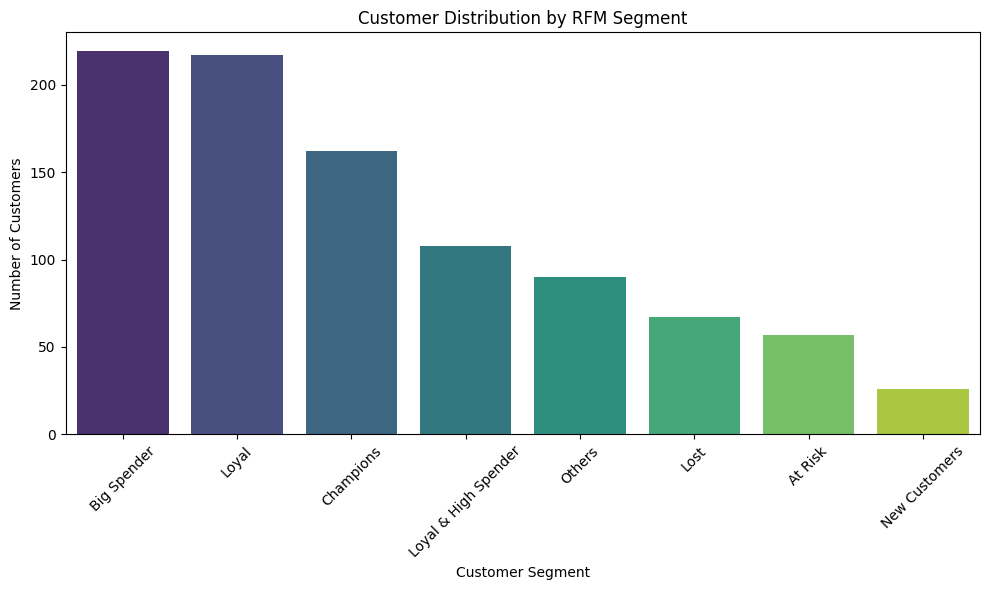

In [49]:
# Step 2: Visualize the Segment Distribution

# Bar plot
plt.figure(figsize=(10,6))
sns.barplot(data=segment_counts, x='Segment', y='CustomerCount', palette='viridis')
plt.title('Customer Distribution by RFM Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


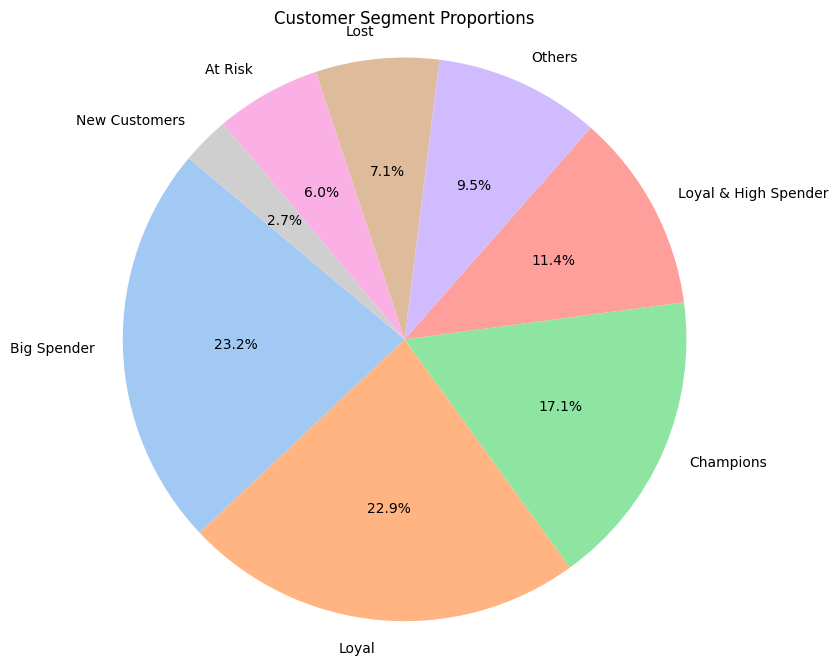

In [50]:
# Step 3: Optional Pie Chart

# Pie chart
plt.figure(figsize=(8,8))
plt.pie(segment_counts['CustomerCount'], labels=segment_counts['Segment'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Customer Segment Proportions')
plt.axis('equal')  # Equal aspect ratio ensures a circular pie chart
plt.show()

Objective 6: Revenue Contribution by Segment: Determine and visualize the total revenue contribution of each RFM segment.


In [51]:
# Step 1: Calculate Total Revenue per Segment

# Group by segment and sum the Monetary value
segment_revenue = rfm.groupby('Segment')['Monetary'].sum().reset_index()

# Sort by revenue descending
segment_revenue = segment_revenue.sort_values(by='Monetary', ascending=False)

# View result
segment_revenue

,Segment,Monetary
1,Big Spender,167237.19
2,Champions,142296.46
5,Loyal & High Spender,79605.33
4,Loyal,57723.24
7,Others,27462.71
3,Lost,18360.27
0,At Risk,17073.92
6,New Customers,3918.69


/tmp/ipython-input-52-3760547980.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_revenue, x='Segment', y='Monetary', palette='YlOrBr')


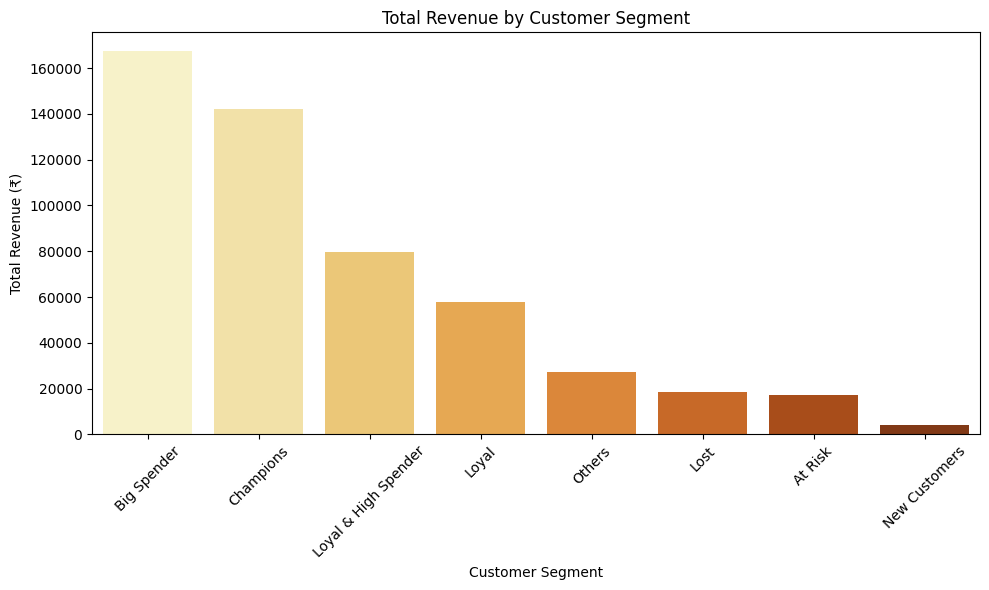

In [52]:
# Step 2: Visualize Revenue by Segment

plt.figure(figsize=(10,6))
sns.barplot(data=segment_revenue, x='Segment', y='Monetary', palette='YlOrBr')
plt.title('Total Revenue by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Total Revenue (₹)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




Objective 7: Recency Distribution: Visualize the distribution of recency scores among the customers.

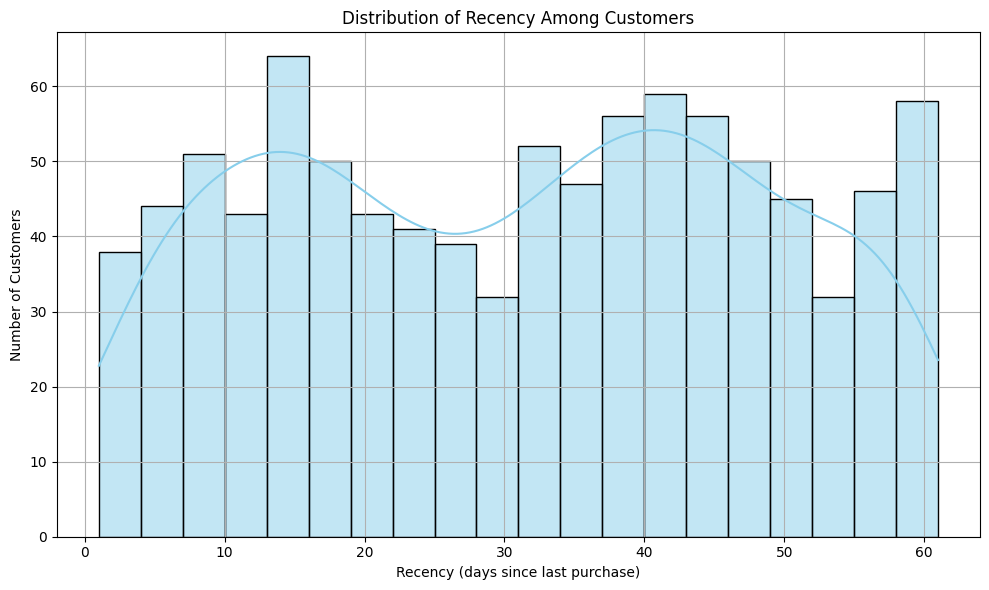

In [53]:
#  Histogram of Recency

plt.figure(figsize=(10,6))
sns.histplot(rfm['Recency'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Recency Among Customers')
plt.xlabel('Recency (days since last purchase)')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.tight_layout()
plt.show()


Objective 8: Frequency Distribution: Visualize the distribution of frequency scores among the customers.


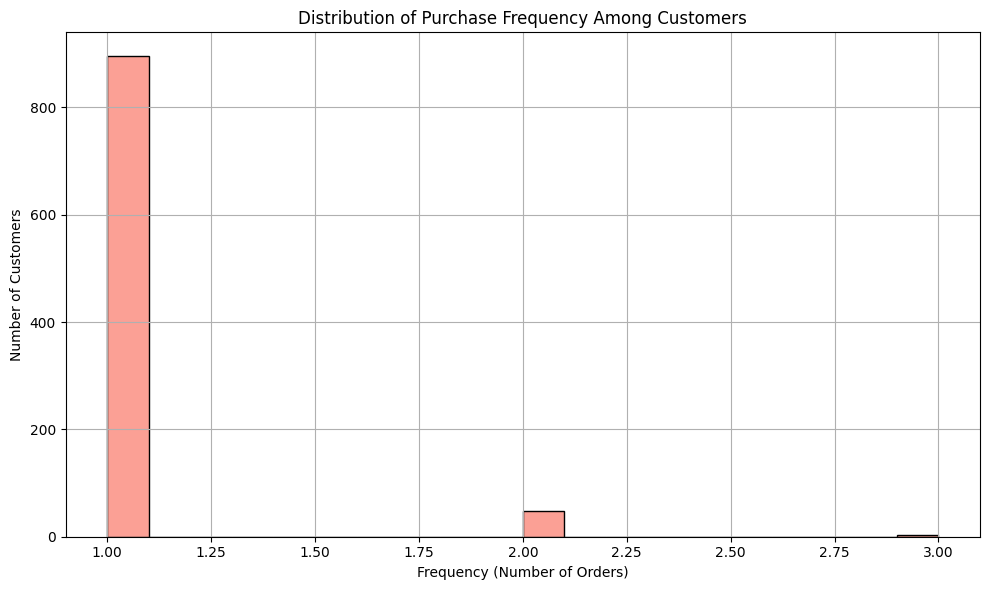

In [54]:
# Histogram of Frequency

plt.figure(figsize=(10,6))
sns.histplot(rfm['Frequency'], bins=20, kde=False, color='salmon')
plt.title('Distribution of Purchase Frequency Among Customers')
plt.xlabel('Frequency (Number of Orders)')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.tight_layout()
plt.show()


Objective 9: Monetary Value Distribution: Visualize the distribution of monetary values among the customers.


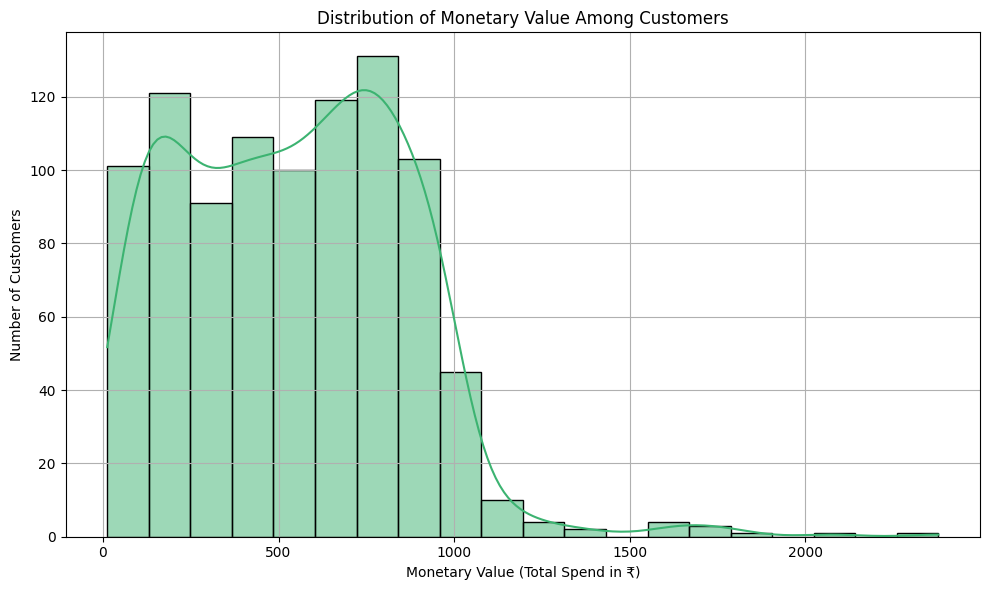

In [55]:
# Histogram of Monetary Value

plt.figure(figsize=(10,6))
sns.histplot(rfm['Monetary'], bins=20, kde=True, color='mediumseagreen')
plt.title('Distribution of Monetary Value Among Customers')
plt.xlabel('Monetary Value (Total Spend in ₹)')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.tight_layout()
plt.show()

Objective 10: Top Segments by Customer Count: Find the RFM segments with the highest number of customers.


In [56]:
# Step 1: Count Customers by RFM_Segment

# Count number of customers per RFM_Segment
segment_counts = rfm['RFM_Segment'].value_counts().reset_index()
segment_counts.columns = ['RFM_Segment', 'CustomerCount']

# View top segments
segment_counts.head(10)

,RFM_Segment,CustomerCount
0,244,25
1,314,21
2,432,21
3,444,20
4,234,20
5,433,20
6,421,20
7,344,20
8,231,20
9,133,20


/tmp/ipython-input-57-3092877305.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_counts.head(10), x='RFM_Segment', y='CustomerCount', palette='coolwarm')


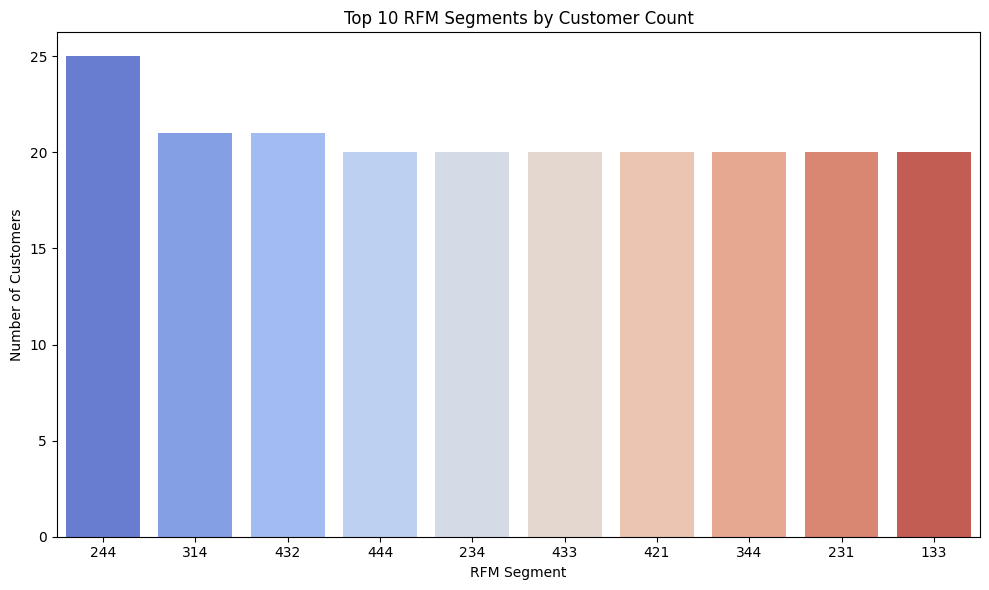

In [57]:
# Step 2: Visualize Top Segments

# Bar chart for top 10 RFM segments
plt.figure(figsize=(10,6))
sns.barplot(data=segment_counts.head(10), x='RFM_Segment', y='CustomerCount', palette='coolwarm')
plt.title('Top 10 RFM Segments by Customer Count')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()

SUBJECTIVE QUESTION

Subjective 1: How would you identify segments with low RFM scores indicating potential churn and what targeted interventions would you implement to retain these customers?


In [58]:
# Step 1: Group by Segment and calculate average RFM score
churn_summary = rfm.groupby('Segment').agg({
    'CustomerID': 'count',
    'R_Score': 'mean',
    'F_Score': 'mean',
    'M_Score': 'mean'
}).rename(columns={'CustomerID': 'CustomerCount'})

# Step 2: Calculate average RFM score
churn_summary['AverageRFMScore'] = churn_summary[['R_Score', 'F_Score', 'M_Score']].mean(axis=1)

# Step 3: Prepare data for plotting
churn_summary = churn_summary.reset_index().sort_values(by='AverageRFMScore')


churn_summary.head(10)



,Segment,CustomerCount,R_Score,F_Score,M_Score,AverageRFMScore
3,Lost,67,1.000000,1.477612,1.492537,1.323383
0,At Risk,57,2.000000,1.491228,1.561404,1.684211
6,New Customers,26,3.576923,1.000000,1.000000,1.858974
7,Others,90,3.522222,1.700000,1.600000,2.274074
1,Big Spender,219,2.415525,1.452055,3.442922,2.436834
4,Loyal,217,2.437788,3.456221,1.465438,2.453149
5,Loyal & High Spender,108,1.694444,3.333333,3.324074,2.783951
2,Champions,162,3.388889,3.543210,3.549383,3.493827


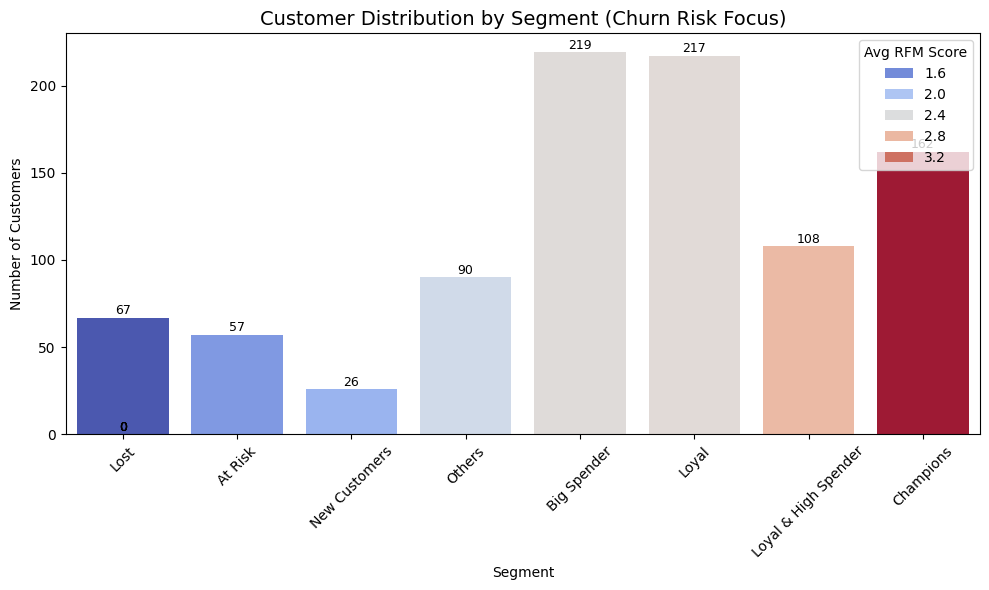

In [59]:
# Step 4:  Visualization

plt.figure(figsize=(10, 6))
bar = sns.barplot(
    data=churn_summary,
    x='Segment',
    y='CustomerCount',
    palette='coolwarm',
    hue='AverageRFMScore',
    dodge=False
)

# Annotate bars with counts
for p in bar.patches:
    height = p.get_height()
    if not pd.isna(height):
        bar.annotate(f'{int(height)}',
                     (p.get_x() + p.get_width() / 2., height + 2),
                     ha='center', fontsize=9)

plt.title('Customer Distribution by Segment (Churn Risk Focus)', fontsize=14)
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.legend(title='Avg RFM Score', loc='upper right')
plt.tight_layout()
plt.show()


Subjective 3: Based on product preferences in each segment, how would you inform product development to enhance features of top-performing products and address gaps in the product line?


In [60]:
# Merge RFM segment info with the original cleaned dataset
df_segmented = df_cleaned.merge(rfm[['CustomerID', 'Segment']], on='CustomerID')

# Group by segment and product
product_pref = df_segmented.groupby(['Segment', 'ProductInformation']).agg({
    'TransactionAmount': 'sum',
    'OrderID': 'count'
}).reset_index()

# Rename for clarity
product_pref.rename(columns={'OrderID': 'OrderCount'}, inplace=True)

# Sort by segment and order count
product_pref = product_pref.sort_values(['Segment', 'OrderCount'], ascending=[True, False])

# Display the output
product_pref.head(10)


,Segment,ProductInformation,TransactionAmount,OrderCount
3,At Risk,Product D,6233.23,19
0,At Risk,Product A,4424.17,14
2,At Risk,Product C,4320.35,14
1,At Risk,Product B,2096.17,10
6,Big Spender,Product C,47759.21,62
5,Big Spender,Product B,44318.17,59
7,Big Spender,Product D,38710.33,51
4,Big Spender,Product A,36449.48,47
10,Champions,Product C,41667.93,63
9,Champions,Product B,33144.24,53


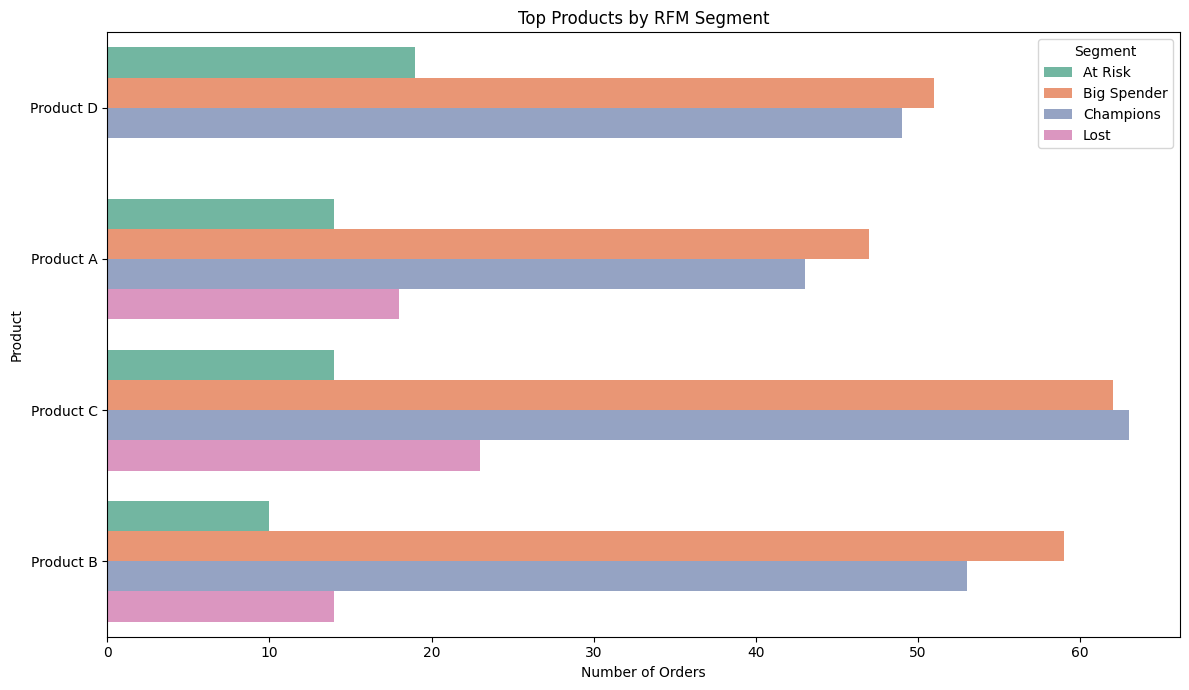

In [61]:
# Step 1: Plot Order Count by Product and Segment

plt.figure(figsize=(12, 7))
sns.barplot(
    data=product_pref.head(15),  # adjust for top N rows
    x='OrderCount',
    y='ProductInformation',
    hue='Segment',
    palette='Set2'
)
plt.title('Top Products by RFM Segment')
plt.xlabel('Number of Orders')
plt.ylabel('Product')
plt.legend(title='Segment')
plt.tight_layout()
plt.show()

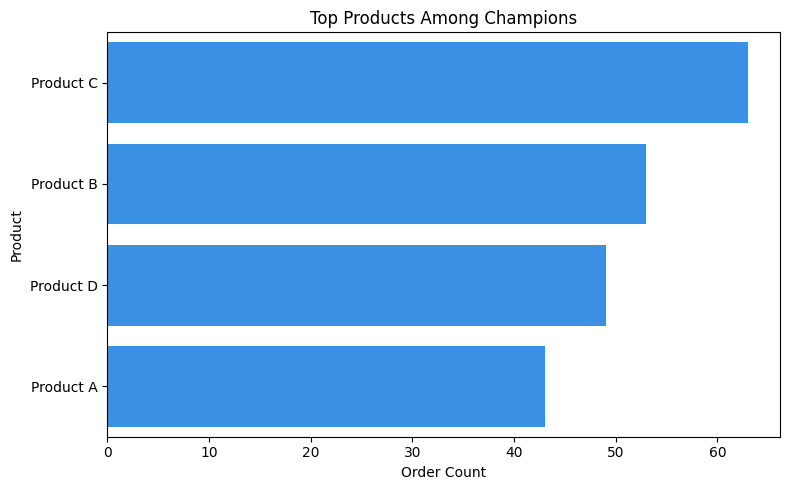

In [62]:
# Optional: Grouped Chart for One Segment at a Time
# To see top products within a specific segment, like "Champions":


champion_pref = product_pref[product_pref['Segment'] == 'Champions'].sort_values('OrderCount', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=champion_pref.head(5), x='OrderCount', y='ProductInformation', color='dodgerblue')
plt.title('Top Products Among Champions')
plt.xlabel('Order Count')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

Subjective 4: How would you leverage geographic data to create targeted marketing campaigns for regions with high-value customers and regions with low engagement?


In [63]:
# Merge RFM segment and Location info
location_df = df_cleaned.merge(rfm[['CustomerID', 'Segment', 'RFM_Score']], on='CustomerID')

# Group by location
location_summary = location_df.groupby('Location').agg({
    'TransactionAmount': 'sum',
    'CustomerID': 'nunique',
    'RFM_Score': 'mean'
}).reset_index().rename(columns={
    'TransactionAmount': 'TotalRevenue',
    'CustomerID': 'CustomerCount',
    'RFM_Score': 'Avg_RFM_Score'
})

# Sort to view highest and lowest value locations
location_summary.sort_values(by='TotalRevenue', ascending=False).head(10)


,Location,TotalRevenue,CustomerCount,Avg_RFM_Score
3,Tokyo,139336.06,270,7.705036
1,New York,132102.79,244,7.765182
0,London,129797.90,244,7.735772
2,Paris,112441.06,228,7.510917


/tmp/ipython-input-64-495325366.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_locs, x='TotalRevenue', y='Location', palette='crest')


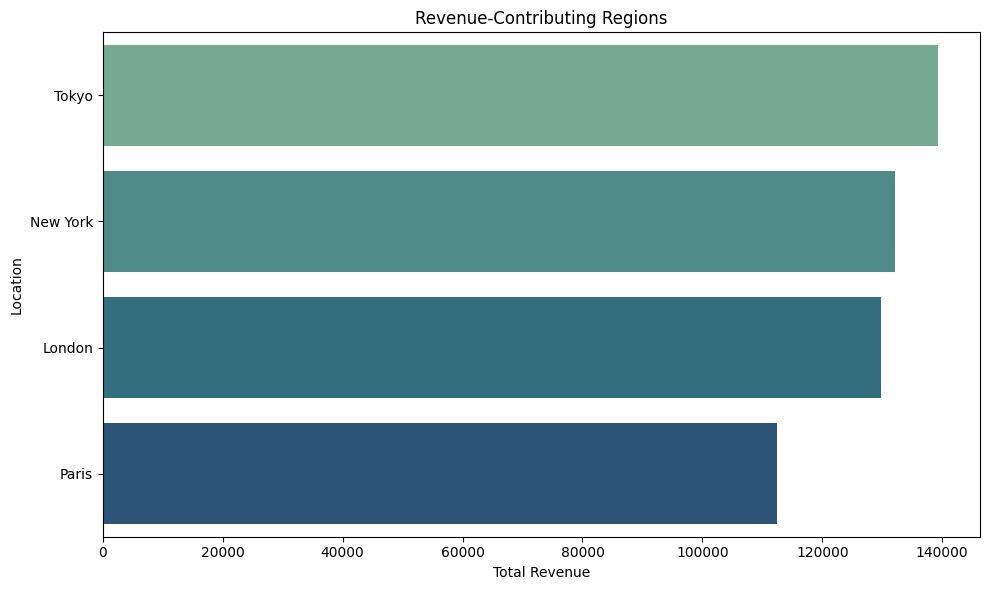

In [64]:
# Bar plot of top revenue regions
plt.figure(figsize=(10,6))
top_locs = location_summary.sort_values(by='TotalRevenue', ascending=False).head(10)
sns.barplot(data=top_locs, x='TotalRevenue', y='Location', palette='crest')
plt.title('Revenue-Contributing Regions')
plt.xlabel('Total Revenue')
plt.ylabel('Location')
plt.tight_layout()
plt.show()


Subjective 5: How would you develop seasonal marketing campaigns based on the seasonal trends observed in different RFM segments to capitalize on peak purchasing times?


In [65]:
# Step 1:  Extract month from the PurchaseDate:


df_cleaned['PurchaseDate'] = pd.to_datetime(df_cleaned['PurchaseDate'], errors='coerce')
df_cleaned['PurchaseMonth'] = df_cleaned['PurchaseDate'].dt.month
df_cleaned[['PurchaseDate', 'PurchaseMonth']].head()


# step 2: Merge RFM with Cleaned Data


df_cleaned['CustomerID'] = df_cleaned['CustomerID'].astype(str)
rfm['CustomerID'] = rfm['CustomerID'].astype(str)

df_seasonal = df_cleaned.merge(rfm[['CustomerID', 'Segment']], on='CustomerID', how='inner')
df_seasonal[['CustomerID', 'Segment', 'PurchaseMonth']].head()

# step 3: Check the Grouped Result

monthly_trends = df_seasonal.groupby(['Segment', 'PurchaseMonth'])['TransactionAmount'].sum().reset_index()
monthly_trends.head(10)




,Segment,PurchaseMonth,TransactionAmount
0,At Risk,4,5886.08
1,At Risk,5,11187.84
2,Big Spender,4,60447.92
3,Big Spender,5,90950.39
4,Big Spender,6,15838.88
5,Champions,4,22630.51
6,Champions,5,78466.22
7,Champions,6,41199.73
8,Lost,4,18360.27
9,Loyal,4,21129.04


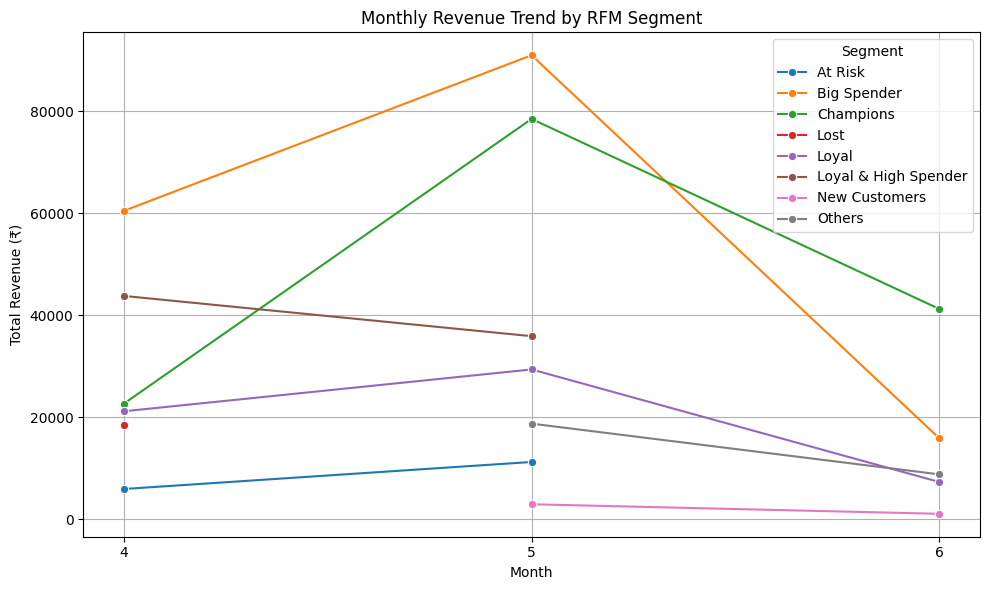

In [66]:
#  Step 4: Visualization

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=monthly_trends,
    x='PurchaseMonth',
    y='TransactionAmount',
    hue='Segment',
    marker='o',
    palette='tab10'
)
plt.title('Monthly Revenue Trend by RFM Segment')
plt.xlabel('Month')
plt.ylabel('Total Revenue (₹)')
plt.xticks([4, 5, 6])
plt.grid(True)
plt.tight_layout()
plt.show()


Subjective 6: How would you identify cross-selling opportunities based on purchase data and create bundled offers for customers in different RFM segments?


In [67]:
# List of products each customer has purchased across multiple orders
customer_products = df_cleaned.groupby('CustomerID')['ProductInformation'].apply(lambda x: list(set(x)))

customer_products.head()


# Count common product combinations across customer history
from itertools import combinations
from collections import Counter

customer_pair_counter = Counter()

for products in customer_products:
    if len(products) > 1:
        pairs = combinations(products, 2)
        customer_pair_counter.update(pairs)

# Create DataFrame
customer_pair_df = pd.DataFrame(customer_pair_counter.items(), columns=['ProductPair', 'Count'])
customer_pair_df = customer_pair_df.sort_values(by='Count', ascending=False)
customer_pair_df.head(10)



,ProductPair,Count
0,"(Product A, Product C)",10
2,"(Product D, Product B)",7
3,"(Product D, Product A)",7
6,"(Product B, Product C)",6
1,"(Product A, Product B)",5
5,"(Product D, Product C)",4
4,"(Product C, Product B)",3


/tmp/ipython-input-68-1641310499.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_pairs, x='Count', y='ProductPair', palette='mako')


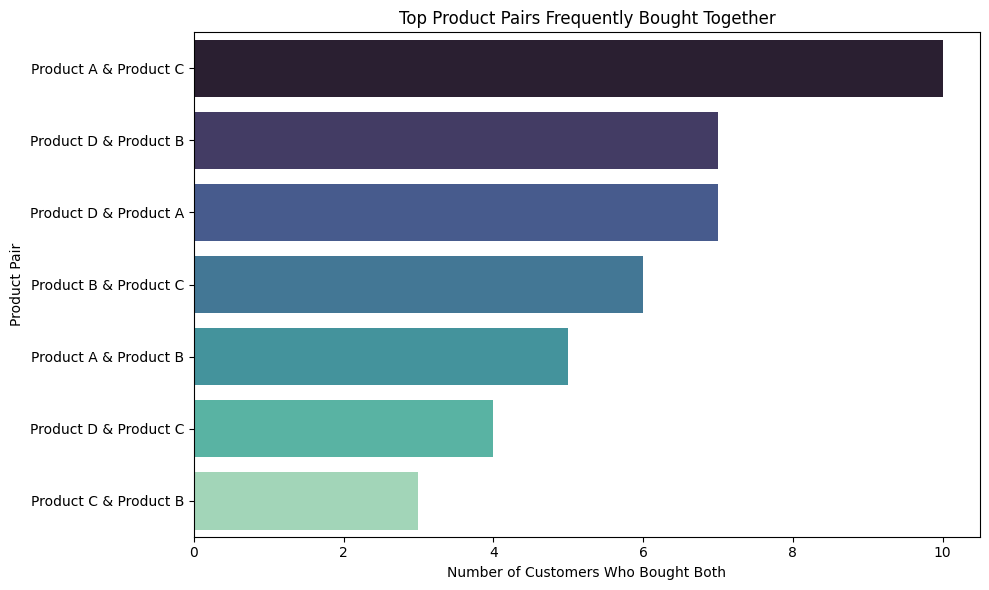

In [68]:
# Visualization

# Data for plotting
top_pairs = customer_pair_df.head(8)
top_pairs['ProductPair'] = top_pairs['ProductPair'].apply(lambda x: f"{x[0]} & {x[1]}")

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_pairs, x='Count', y='ProductPair', palette='mako')
plt.title('Top Product Pairs Frequently Bought Together')
plt.xlabel('Number of Customers Who Bought Both')
plt.ylabel('Product Pair')
plt.tight_layout()
plt.show()


Subjective 7: Without direct feedback data, how would you use indirect feedback such as repeat purchases and product returns to refine RFM segmentation and improve customer satisfaction?


In [69]:
# Track product-level repeat purchase rates:

# Customers with more than one order
repeat_buyers = df_cleaned.groupby('CustomerID')['OrderID'].nunique().reset_index()
repeat_buyers['Is_Repeat_Buyer'] = repeat_buyers['OrderID'] > 1
repeat_buyers['Is_Repeat_Buyer'].value_counts()


,count
Is_Repeat_Buyer,
False,895
True,51


Subjective 8: How would you analyze the revenue variation by day of the week for different RFM segments to identify patterns and optimize marketing efforts?


In [70]:
# Step 1: Extract Day of the Week

df_cleaned['PurchaseDate'] = pd.to_datetime(df_cleaned['PurchaseDate'], errors='coerce')
df_cleaned['DayOfWeek'] = df_cleaned['PurchaseDate'].dt.day_name()

# Step 2: Merge with RFM Segments

df_segmented = df_cleaned.merge(rfm[['CustomerID', 'Segment']], on='CustomerID', how='inner')

# Group by Segment + Day

dow_revenue = df_segmented.groupby(['Segment', 'DayOfWeek'])['TransactionAmount'].sum().reset_index()

# Optional: Order Days Properly

from pandas.api.types import CategoricalDtype

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_cat = CategoricalDtype(categories=day_order, ordered=True)
dow_revenue['DayOfWeek'] = dow_revenue['DayOfWeek'].astype(dow_cat)
dow_revenue = dow_revenue.sort_values('DayOfWeek')

dow_revenue.head(10)


,Segment,DayOfWeek,TransactionAmount
1,At Risk,Monday,3195.54
35,Loyal & High Spender,Monday,8142.46
49,Others,Monday,6346.15
28,Loyal,Monday,9225.90
42,New Customers,Monday,314.15
7,Big Spender,Monday,20491.89
14,Champions,Monday,22427.95
21,Lost,Monday,2843.98
46,New Customers,Tuesday,721.45
32,Loyal,Tuesday,8328.39


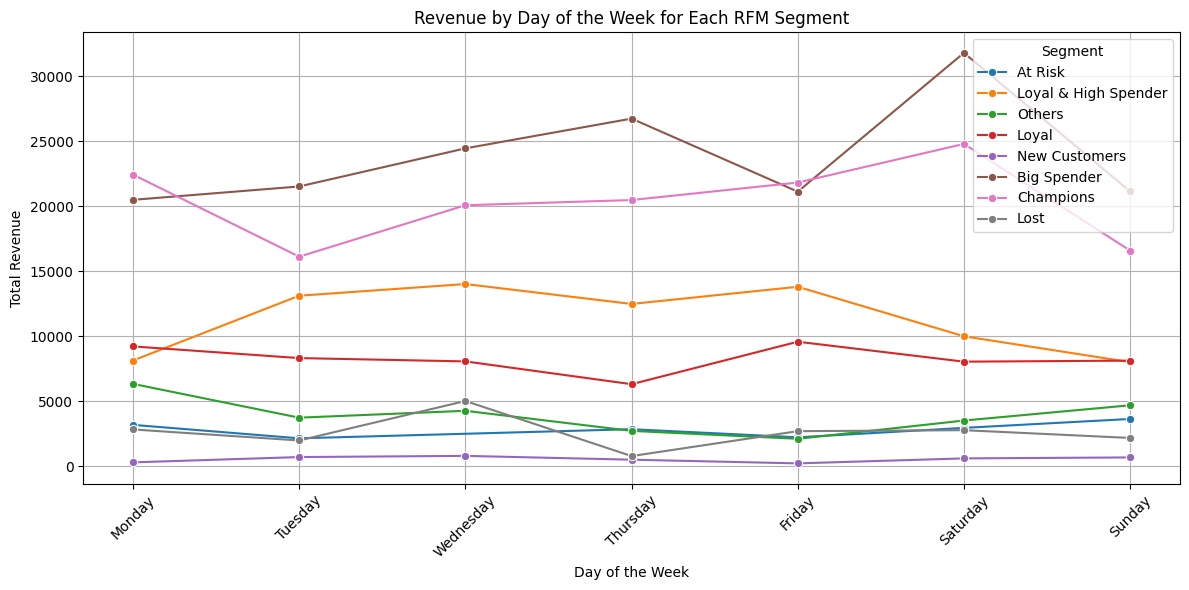

In [71]:
# Visualize the Revenue Pattern

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=dow_revenue,
    x='DayOfWeek',
    y='TransactionAmount',
    hue='Segment',
    marker='o',
    palette='tab10'
)
plt.title('Revenue by Day of the Week for Each RFM Segment')
plt.xlabel('Day of the Week')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



